In [4]:
#my stuff
import icu_data_defs
import transformers
import utils
import features
from constants import column_names,variable_type,clinical_source
import units
import mimic
import logger

#other stuff
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

#make pretty pictures
import seaborn as sns
%matplotlib inline

In [24]:
#HELPER FUNCTIONS

def run_crossval(pipeline,X,y):
    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=10)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error',cv=10)

    print 'Cross Validation, K-Fold'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())

    cv_shuffle = ShuffleSplit(n_splits=10,test_size=0.1)

    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=cv_shuffle)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error', cv=cv_shuffle)

    print '\nCross Validation, ShuffleSplit'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())
    return

"""
Getting lactate labels (next and delta)
"""
def get_labels_next_lac(lactate_series):
    return lactate_series.shift(-1).dropna().iloc[:,0]

def get_labels_delta_lac(lactate_series):
    id_grouped = lactate_series.groupby(level='id')
    lac_filled = id_grouped.ffill()
    lac_next = id_grouped.shift(-1)
    lac_all = lac_filled
    lac_all.columns = ['last']
    lac_all['next'] = lac_next
    lac_all = lac_all.dropna()
    return lac_all['next'] - lac_all['last']


"""
Visualize data
"""
#Visualize
def hist_corr_per_feature(df_features,label_dict):  
    plot_cnt = len(label_dict)+1
    
    for col_name in df:
        print col_name
        col = df[col_name]
        display(col.describe().apply(lambda x: '%.4f' % x).to_frame())
        #determine # of filled values
        mode = col.mode()
        mode_count = (df[col] == mode).sum()
        print "MODE:",mode
        print mode_count
        print mode_count/float(col.shape[0])


        # plot histogram of column (all of df_train)
        fig, axarr  = plt.subplots(1,plot_cnt,figsize=(5*(plot_cnt), 5))
        ax = plt.subplot(1, plot_cnt, 1)
        std = col.std()
        mean = col.mean()
        col.loc[(col < (mean + 3.0*std)) & (col > (mean - 3.0*std))].hist()
        ax.set_title('{}_{}\n{}'.format(col_name[0],col_name[1],col_name[2:]))
        ax.set_xlabel(col[-2])
        ax.set_ylabel('COUNT')

        #plot this column vs. each label
        for i,label_name in label_dict.keys():
            
            y = label_dict[label_name]
            
            x = col.loc[y.index]
            ax = plt.subplot(1, plot_cnt, 1+i)
            sns.regplot(x, y)
            corr = np.corrcoef(x, y)[0][1]
            ax.set_title('{} \n PCC (r) = {}'.format(label_name,corr))
        
        plt.tight_layout()
        plt.show()
        
"""
Test/train/validate split
"""

def test_train_val_split(all_ids=None,test_size=0.1,random_state=42,print_ids=False):

    if all_ids is None:
        all_ids = mimic.get_all_hadm_ids()
    
    validate_size = test_size/(1-test_size)
    train_size = (1-test_size)*(1-validate_size)
    #these test IDs will never be touched again. They are sacred
    train_val_ids,test_ids = train_test_split(all_ids,test_size=test_size,random_state=random_state)
    train_ids,validate_ids = train_test_split(train_val_ids,test_size=validate_size,random_state=random_state)

    if print_ids:
        print 'Train {}:'.format(int(train_size*100)), len(train_ids),'>',train_ids[:5],'...'
        print 'Validate {}:'.format(int(train_size*100)), len(validate_ids),'>',validate_ids[:5],'...'
        print 'Test {}:'.format(int(test_size*100)), len(test_ids),'>',test_ids[:5],'...'
    return train_ids,validate_ids,test_ids

# Set up

In [28]:
#test/train/val split
train_ids,validate_ids,test_ids = test_train_val_split(print_ids=True);

# Load Our Data Dict
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')
display(data_dict.get_defs())

#init ETL Manager => mimic_extract data
hdf5_fname = 'data/mimic_extract.h5'
mimic_etlM = mimic.MimicETLManager(hdf5_fname,'config/mimic_item_map.csv',data_dict)

#init feature factory using data_dict, etl_manager
factory = features.DataSetFactory(features=None,
                                      resample_freq=None,
                                      data_dict=data_dict,
                                      ETL_manager=mimic_etlM,
                                      hdf5_fname_target=None,
                                  )

#create all features
m_ureg = units.MedicalUreg()
is_summable = lambda x: m_ureg.is_volume(str(x)) or m_ureg.is_mass(str(x))

"""
Data Specs
"""
qn_not_sum = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE,
    column_names.UNITS: lambda units: not is_summable(units)
}

weight = {
    column_names.COMPONENT : data_dict.components.WEIGHT_BODY
}

intervention_summable = {
    column_names.CLINICAL_SOURCE : clinical_source.INTERVENTION,
    column_names.UNITS: is_summable
}

uop_summable = {
    column_names.COMPONENT : data_dict.components.OUTPUT_URINE,
    column_names.UNITS: is_summable
}

not_nominal = {
    column_names.VAR_TYPE : [variable_type.QUANTITATIVE, variable_type.ORDINAL]
}

is_nominal = {
    column_names.VAR_TYPE : variable_type.NOMINAL
}

"""
Features
"""
# MEAN & LAST
# For all non-summable quantities: 
# 1. ffill values
# 2. Then resample and aggregate 
# 3. Then fill with mean of means
f_qn_mean = features.Feature('MEAN','mean',
                               data_specs=[qn_not_sum,weight],
                               pre_processor=transformers.GroubyAndFFill(level=column_names.ID),
                               fillna_method=transformers.fill_mean()
                            )

f_qn_most_recent = features.Feature('LAST','last',
                                       data_specs=[qn_not_sum,weight],
                                       pre_processor=transformers.GroubyAndFFill(level=column_names.ID),
                                       fillna_method=transformers.fill_mean()
                                   )
# STD - fill NaN with 0
f_qn_std = features.Feature('STD','std',
                                data_specs=[not_nominal],
                                fillna_method=transformers.fill_zero()
                           )

# SUM - for UOP volumes and intervention volumes/masses
f_sum = features.Feature('SUM','sum',
                             data_specs=[intervention_summable,uop_summable],
                             fillna_method=transformers.fill_zero()
                        )

#only COUNT ordinal or quantitative data
f_count = features.Feature('COUNT','count',
                           data_specs=[not_nominal],
                           fillna_method=transformers.fill_zero())

#use SUM for nominal data (0's will be counted if we use count)
f_count_nom = features.Feature('COUNT','sum',
                             data_specs=[is_nominal],
                             fillna_method=transformers.fill_zero()
                        )

"""
Lactate Label
"""
# Label is lactate. just resampling; no preprocessing or filling
label = features.Feature('LABEL','mean',{
                                column_names.COMPONENT : data_dict.components.LACTATE,
                                column_names.VAR_TYPE : variable_type.QUANTITATIVE
                            })

Train 80: 47180 > [139698, 127590, 178959, 139276, 196600] ...
Validate 80: 5898 > [112338, 107467, 158733, 144544, 115417] ...
Test 10: 5898 > [167957, 164747, 124147, 184424, 136508] ...


,component,units,variable_type,clinical_source,lower,upper,list_id
def_id,,,,,,,
0,heart rate,beats/min,qn,observation,0.0,500.0,NaN
1,blood pressure systolic,mmHg,qn,observation,0.0,500.0,NaN
2,blood pressure diastolic,mmHg,qn,observation,0.0,500.0,NaN
3,blood pressure mean,mmHg,qn,observation,0.0,500.0,NaN
4,respiratory rate,insp/min,qn,observation,0.0,150.0,NaN
5,temperature body,degF,qn,observation,0.0,150.0,NaN
6,oxygen saturation pulse oximetry,percent,qn,observation,0.0,100.0,NaN
7,weight body,kg,qn,observation,0.0,700.0,NaN
8,output urine,mL,qn,observation,0.0,30000.0,NaN


## Smaller Data Set

In [8]:
reload(logger)

train_subset = pd.Series(train_ids).sample(frac=0.2, random_state=random_state).sort_values().tolist()

print train_subset[:5], len(train_subset)

[100014L, 100029L, 100039L, 100046L, 100052L] 9436


In [9]:
factory.hdf5_fname_target = 'data/combine_like.h5'
factory.resample_freq='2H'
factory.pre_processors = Pipeline([
                                ('drop_small_columns',transformers.remove_small_columns(threshold=100)),
                                ('drop_low_id_count',transformers.record_threshold(threshold=20)),
                                ('combine_like_columns',transformers.combine_like_cols())
                            ])
factory.features = [f_qn_mean,f_qn_most_recent,f_qn_std,f_sum,f_count,f_count_nom,label]
factory.get_params()

{'ETL_manager': <mimic.MimicETLManager at 0xf4463c8>,
 'data_dict': <icu_data_defs.data_dictionary at 0xbac1ba8>,
 'features': [<features.Feature at 0xf724f98>,
 'force_preprocessing': True,
 'hdf5_fname_target': 'data/combine_like.h5',
 'pre_processors': Pipeline(steps=[('drop_small_columns', remove_small_columns(threshold=100)), ('drop_low_id_count', record_threshold(threshold=20)), ('combine_like_columns', combine_like_cols())]),
 'pre_processors__combine_like_columns': combine_like_cols(),
 'pre_processors__drop_low_id_count': record_threshold(threshold=20),
 'pre_processors__drop_low_id_count__threshold': 20,
 'pre_processors__drop_small_columns': remove_small_columns(threshold=100),
 'pre_processors__drop_small_columns__threshold': 100,
 'pre_processors__steps': [('drop_small_columns',
   remove_small_columns(threshold=100)),
  ('drop_low_id_count', record_threshold(threshold=20)),
  ('combine_like_columns', combine_like_cols())],
 'resample_freq': '2H',
 'save_ETL_steps': False}

In [16]:
df_train = factory.fit_transform(train_subset)

(2017-08-01 11:32:23) FEATURIZE... #F=7, #ids=4718, fit->True
(2017-08-01 11:32:23)>> PRE-PROCESSING & JOIN: #C=57, ['alanine aminotransferase serum', 'alkaline phosphatase serum', 'aspartate aminotransferase serum', 'bicarbonate arterial', 'bicarbonate other', 'blood pressure diastolic', 'blood pressure mean', 'blood pressure systolic', 'blood urea nitrogen serum', 'calcium ionized serum', 'calcium total serum', 'carbon dioxide serum', 'central venous oxygen saturation', 'central venous pressure', 'chloride serum', 'creatinine serum', 'end tidal cardon dioxide', 'fraction of inspired oxygen', 'glasgow coma scale eye opening', 'glasgow coma scale motor', 'glasgow coma scale verbal', 'glucose fingerstick', 'glucose serum', 'heart rate', 'hematocrit', 'hemoglobin', 'international normalized ratio', 'lactate', 'lactated ringers', 'magnesium serum', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'norepinephrine', 'normal saline', 'out

In [17]:
df_train.shape

(558627, 369)

In [14]:
idx = pd.IndexSlice

In [21]:
df_train.sort_index(axis=1).loc[:,idx[:,:,:,'nom',:,:]].sum()

feature  component                    status   variable_type  units     description                     
COUNT    output urine                 unknown  nom            no_units  3686(ml)_No Void                      402.000000
                                                                        3686(ml)_Voiding qs                 40324.000000
                                                                        3686_Voiding qs                        54.000000
         partial thromboplastin time  unknown  nom            no_units  51275(sec)_>150                        79.000000
         potassium serum              unknown  nom            no_units  1535(mEq/L)_20kcl                      55.000000
                                                                        1535(mEq/L)_20meq                     101.000000
                                                                        829(mEq/L)_20kcl                       55.000000
                                                

In [105]:
#lets try a harsher filter for data volume thresholds; at least 1000 values across at least 100 admissions

factory.hdf5_fname_target = 'data/combine_like_harsh.h5' #note new name for target hdf5_fname
factory.pre_processors = Pipeline([
                                ('drop_small_columns',transformers.remove_small_columns(threshold=1000)),
                                ('drop_low_id_count',transformers.record_threshold(threshold=100)),
                                ('combine_like_columns',transformers.combine_like_cols())
                            ])
factory.get_params()

{'ETL_manager': <mimic.MimicETLManager at 0xf4463c8>,
 'data_dict': <icu_data_defs.data_dictionary at 0xbac1ba8>,
 'features': [<features.Feature at 0xf724f98>,
 'force_preprocessing': True,
 'hdf5_fname_target': 'data/combine_like_harsh.h5',
 'pre_processors': Pipeline(steps=[('drop_small_columns', remove_small_columns(threshold=1000)), ('drop_low_id_count', record_threshold(threshold=100)), ('combine_like_columns', combine_like_cols())]),
 'pre_processors__combine_like_columns': combine_like_cols(),
 'pre_processors__drop_low_id_count': record_threshold(threshold=100),
 'pre_processors__drop_low_id_count__threshold': 100,
 'pre_processors__drop_small_columns': remove_small_columns(threshold=1000),
 'pre_processors__drop_small_columns__threshold': 1000,
 'pre_processors__steps': [('drop_small_columns',
   remove_small_columns(threshold=1000)),
  ('drop_low_id_count', record_threshold(threshold=100)),
  ('combine_like_columns', combine_like_cols())],
 'resample_freq': '6H',
 'save_ETL_

In [11]:
df_train = factory.fit_transform(train_subset)

(2017-08-01 12:43:56) FEATURIZE... #F=7, #ids=9436, fit->True
(2017-08-01 12:43:56)>> PRE-PROCESSING & JOIN: #C=57, ['alanine aminotransferase serum', 'alkaline phosphatase serum', 'aspartate aminotransferase serum', 'bicarbonate arterial', 'bicarbonate other', 'blood pressure diastolic', 'blood pressure mean', 'blood pressure systolic', 'blood urea nitrogen serum', 'calcium ionized serum', 'calcium total serum', 'carbon dioxide serum', 'central venous oxygen saturation', 'central venous pressure', 'chloride serum', 'creatinine serum', 'end tidal cardon dioxide', 'fraction of inspired oxygen', 'glasgow coma scale eye opening', 'glasgow coma scale motor', 'glasgow coma scale verbal', 'glucose fingerstick', 'glucose serum', 'heart rate', 'hematocrit', 'hemoglobin', 'international normalized ratio', 'lactate', 'lactated ringers', 'magnesium serum', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'norepinephrine', 'normal saline', 'out

In [12]:
df_train.shape

(1088895, 280)

In [15]:
df_train.sort_index(axis=1).loc[:,idx[:,:,:,'nom',:,:]].sum()

feature  component               status   variable_type  units     description                 
COUNT    output urine            unknown  nom            no_units  3686(ml)_Voiding qs             71767.0
         red blood cell count    unknown  nom            no_units  51493(#/hpf)(number/hpf)_0-2     1345.0
         white blood cell count  unknown  nom            no_units  51516(#/hpf)(number/hpf)_0-2     1926.0
dtype: float64

In [57]:
y_next = get_labels_next_lac(df_train.loc[:,'LABEL'])
X_next = df_train.drop('LABEL',axis=1).loc[y_next.index]

In [58]:
y_delta = get_labels_delta_lac(df_train.loc[:,'LABEL'])
X_delta = df_train.drop('LABEL',axis=1).loc[y_delta.index]

In [99]:
dict_fill_vals = {}
for f,pipeline in factory.feature_pipelines:
    fill_na = pipeline.steps[3][1]
    if isinstance(fill_na,transformers.fill_mean):
        print f.name
        print fill_na.means
        dict_fill_vals[f.name] = fill_na.means

MEAN
component                                    status   variable_type  units       description
alanine aminotransferase serum               unknown  qn             IU/L        all             74.185834
alkaline phosphatase serum                   known    qn             IU/L        all            170.929845
aspartate aminotransferase serum             unknown  qn             IU/L        all             96.180886
bicarbonate arterial                         known    qn             mEq/L       all             23.975325
bicarbonate other                            known    qn             mEq/L       all             24.959631
blood pressure diastolic                     known    qn             mmHg        all             60.866805
                                             unknown  qn             cc/min      all             39.060365
blood pressure mean                          known    qn             mmHg        all             78.921064
blood pressure systolic                      k

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,alanine aminotransferase serum
,unknown
,qn
,IU/L
,all
count,1088895.000
mean,74.186
std,196.226
min,0.000
25%,47.000


722195
0.663236583876


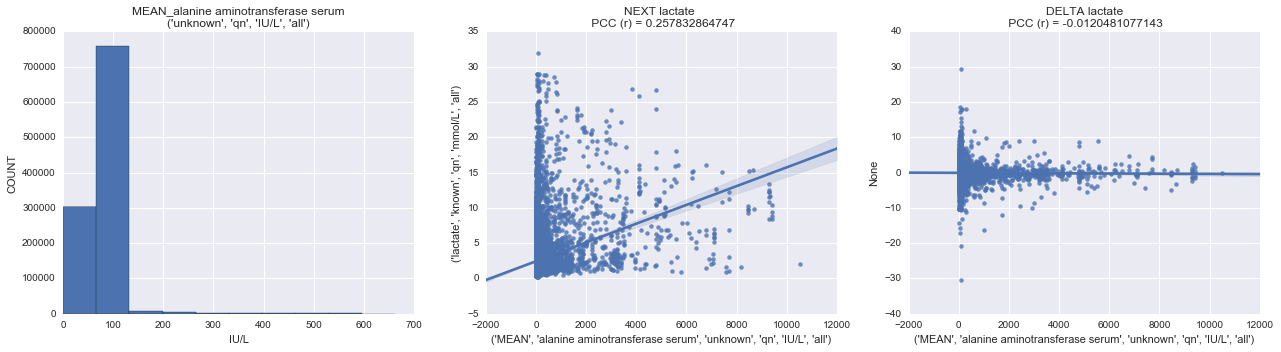

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,alkaline phosphatase serum
,known
,qn
,IU/L
,all
count,1088895.000
mean,170.930
std,108.207
min,0.000
25%,154.000


686387
0.630351870474


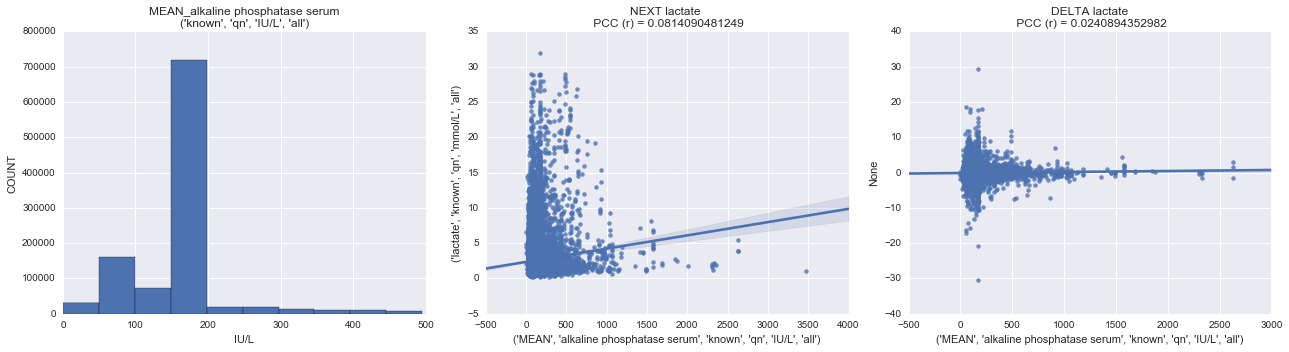

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,aspartate aminotransferase serum
,unknown
,qn
,IU/L
,all
count,1088895.000
mean,96.181
std,287.657
min,1.000
25%,62.000


722676
0.663678316091


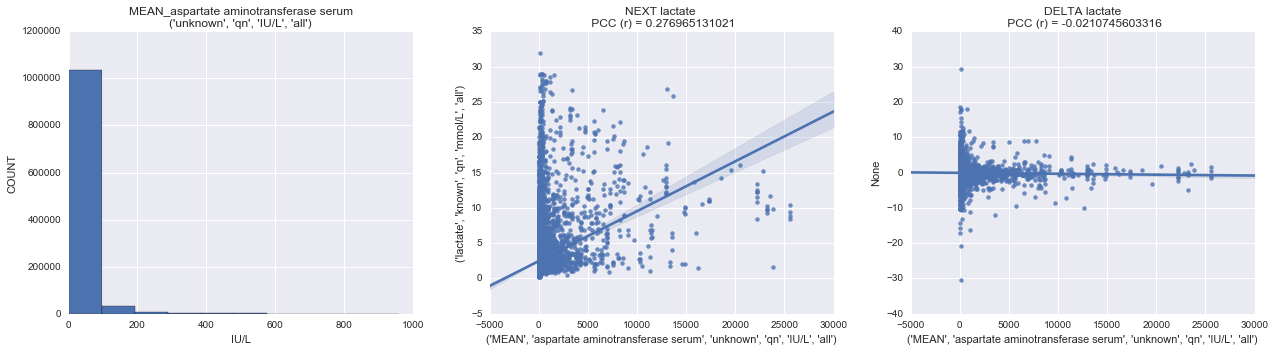

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,bicarbonate arterial
,known
,qn
,mEq/L
,all
count,1088895.000
mean,23.975
std,1.778
min,2.500
25%,23.975


1002025
0.920221876306


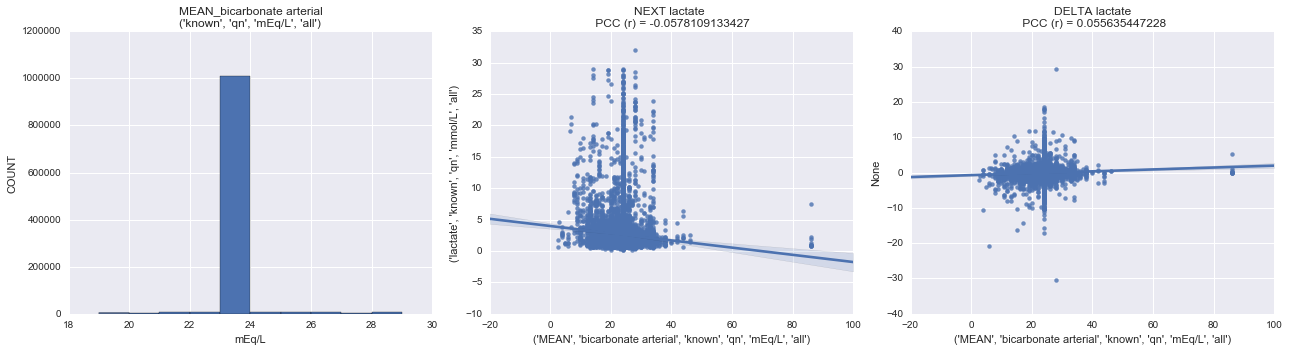

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,bicarbonate other
,known
,qn
,mEq/L
,all
count,1088895.000
mean,24.960
std,3.656
min,0.000
25%,24.000


473578
0.434916130573


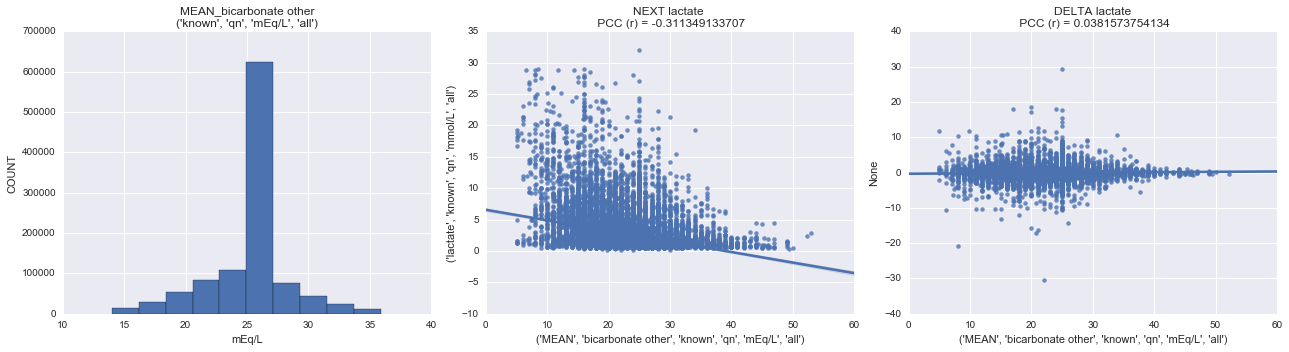

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood pressure diastolic
,known
,qn
,mmHg
,all
count,1088895.000
mean,60.867
std,8.848
min,0.000
25%,60.867


633369
0.581662143733


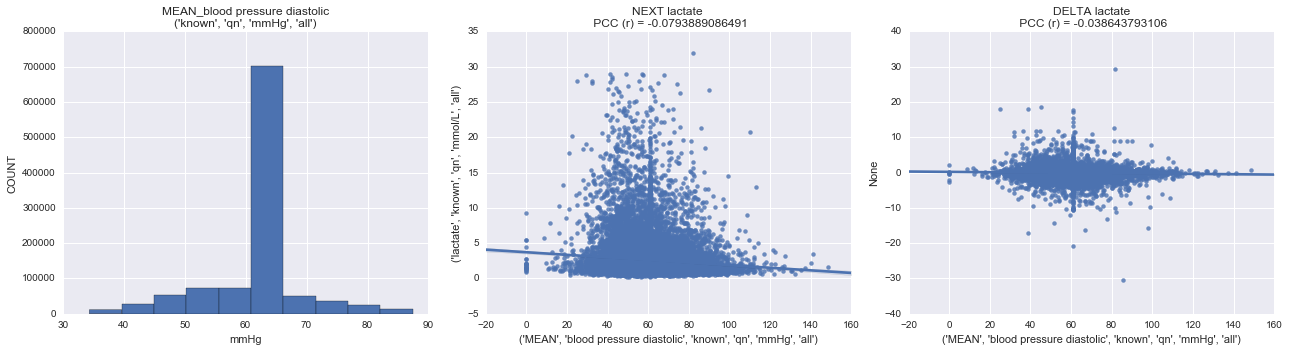

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood pressure diastolic
,unknown
,qn
,cc/min
,all
count,1088895.000
mean,39.060
std,3.452
min,0.000
25%,39.060


932612
0.856475601412


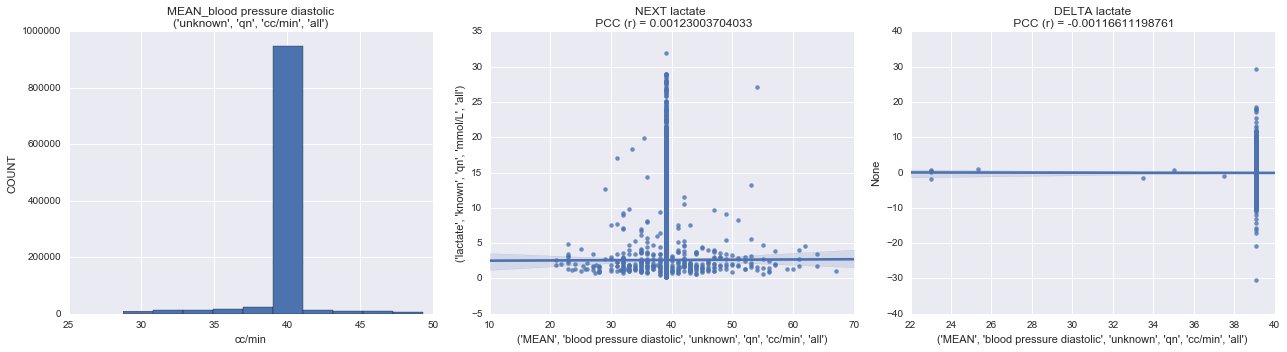

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood pressure mean
,known
,qn
,mmHg
,all
count,1088895.000
mean,78.921
std,6.382
min,0.000
25%,78.921


908168
0.83402715597


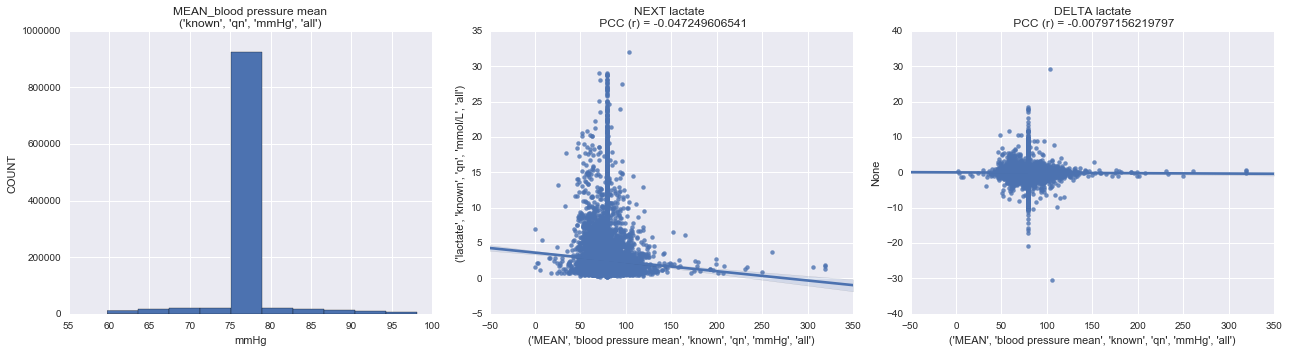

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood pressure systolic
,known
,qn
,mmHg
,all
count,1088895.000
mean,122.285
std,14.168
min,0.000
25%,122.285


633370
0.581663062095


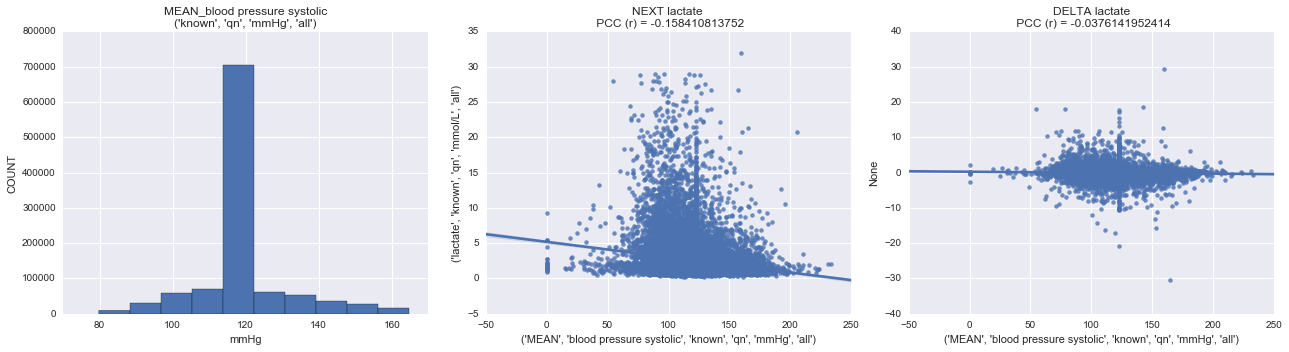

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood pressure systolic
,unknown
,qn
,cc/min
,all
count,1088895.000
mean,69.935
std,3.869
min,0.000
25%,69.935


932612
0.856475601412


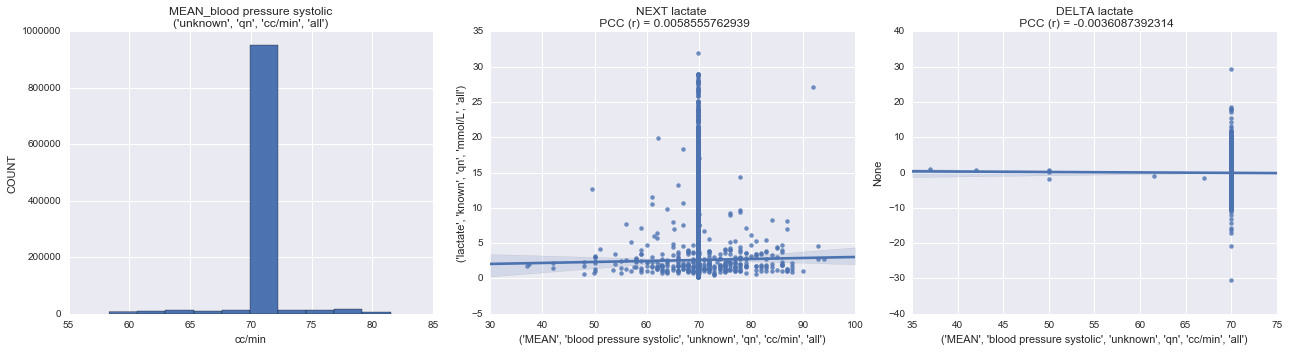

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,blood urea nitrogen serum
,known
,qn
,mg/dL
,all
count,1088895.000
mean,29.122
std,16.300
min,0.000
25%,21.000


533547
0.489989392917


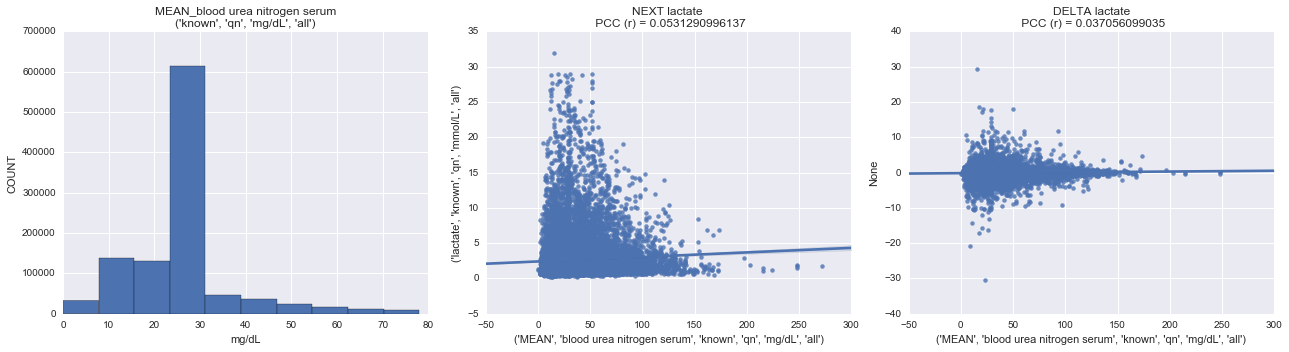

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,calcium ionized serum
,unknown
,qn
,mmol/L
,all
count,1088895.000
mean,1.471
std,3.678
min,-42.000
25%,1.200


736712
0.67656844783


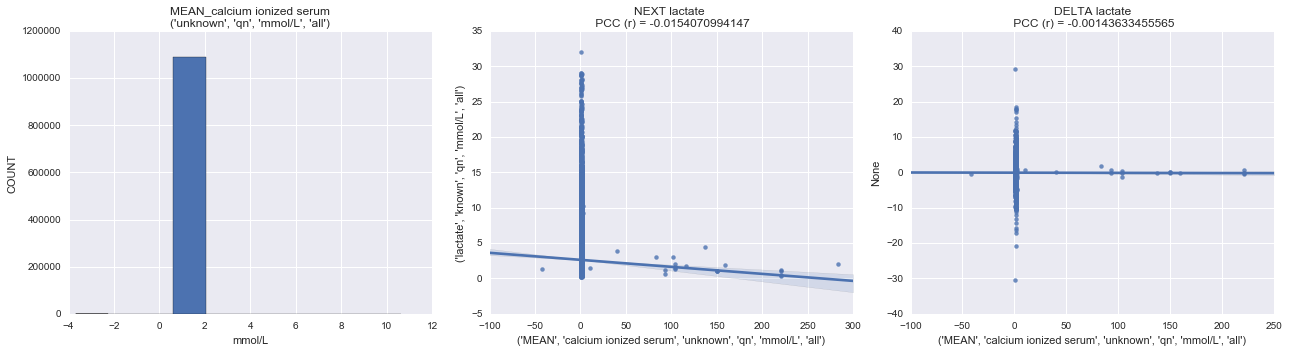

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,calcium total serum
,known
,qn
,mg/dL
,all
count,1088895.000
mean,8.607
std,0.675
min,0.000
25%,8.500


573877
0.527026940155


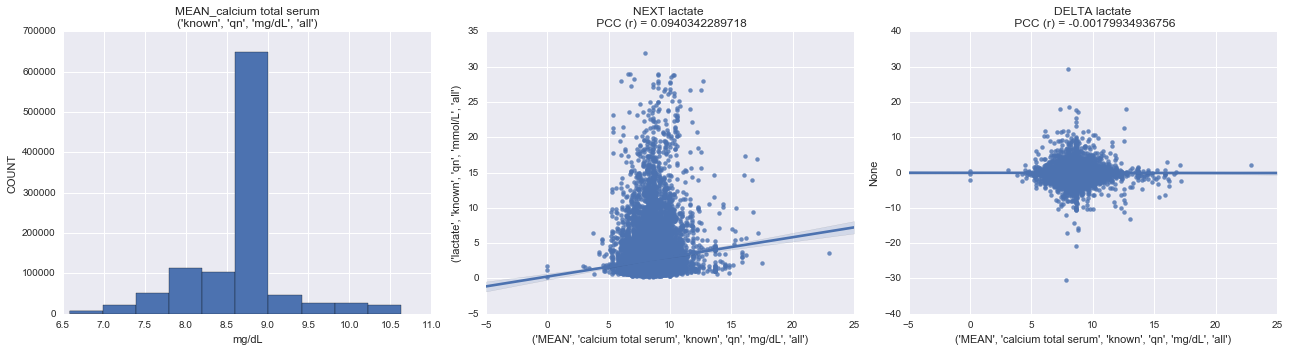

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,carbon dioxide serum
,unknown
,qn
,no_units
,all
count,1088895.000
mean,24.682
std,2.976
min,2.000
25%,24.682


681917
0.626246791472


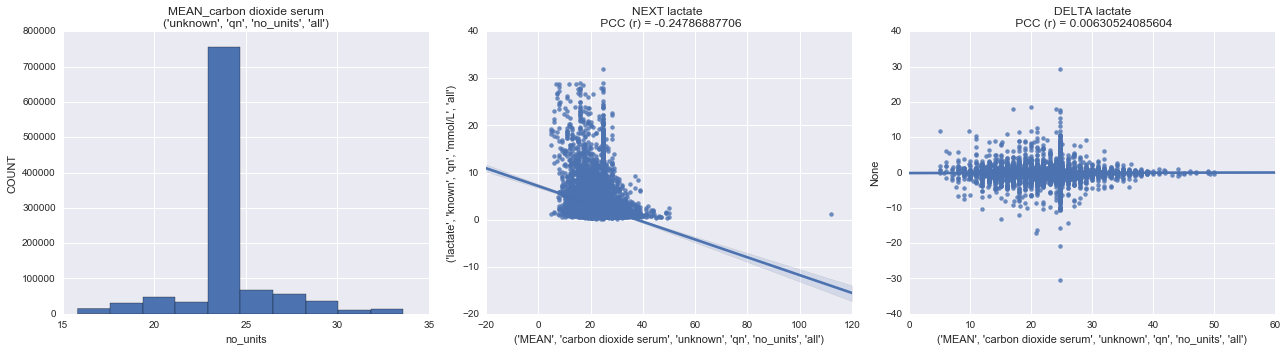

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,central venous oxygen saturation
,known
,qn
,percent
,all
count,1088895.000
mean,70.566
std,2.180
min,16.000
25%,70.566


1054495
0.968408340565


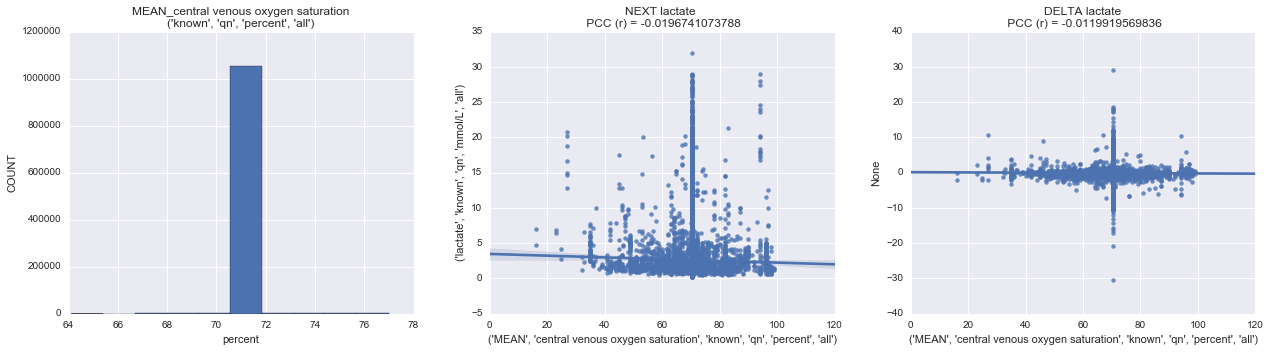

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,central venous oxygen saturation
,unknown
,qn
,no_units
,all
count,1088895.000
mean,69.744
std,2.381
min,23.000
25%,69.744


1017096
0.934062512914


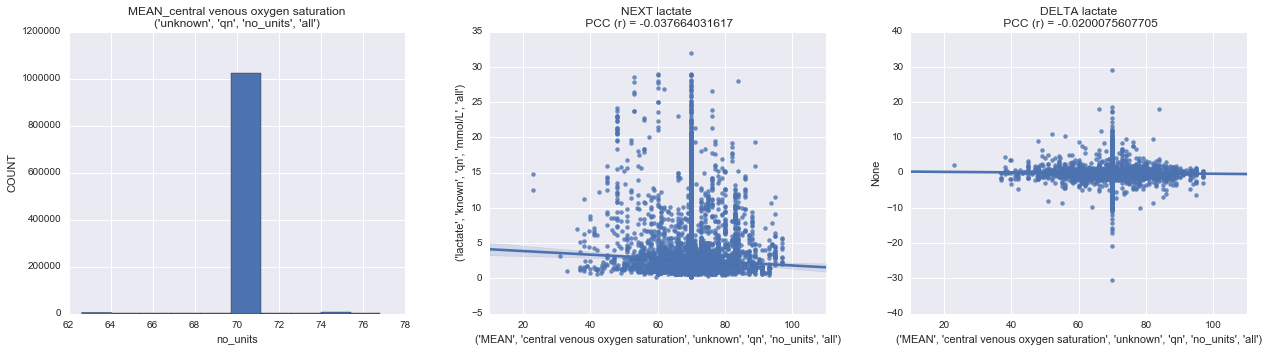

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,central venous pressure
,unknown
,qn
,mmHg
,all
count,1088895.000
mean,15.459
std,15.564
min,-39.000
25%,15.459


852495
0.782899177607


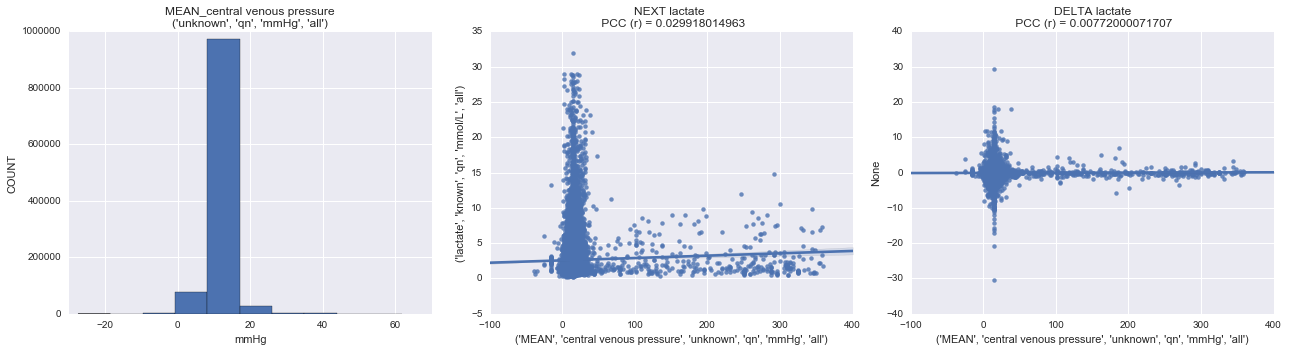

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,chloride serum
,unknown
,qn
,mEq/L
,all
count,1088895.000
mean,104.950
std,134.289
min,0.000
25%,103.000


469044
0.43075227639


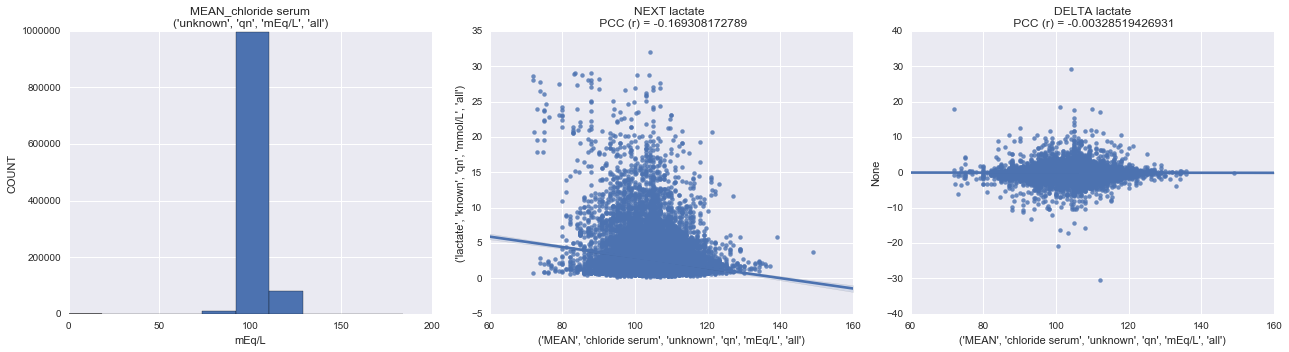

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,creatinine serum
,known
,qn
,mg/dL
,all
count,1088895.000
mean,1.351
std,1.078
min,0.000
25%,0.900


533140
0.489615619504


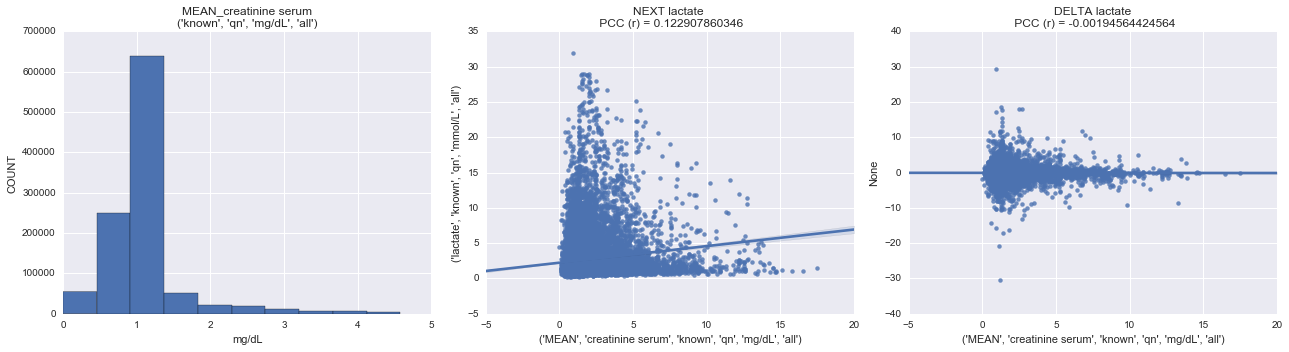

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,fraction of inspired oxygen
,known
,qn
,percent
,all
count,1088895.000
mean,49.561
std,11.874
min,21.000
25%,49.561


959494
0.881163013881


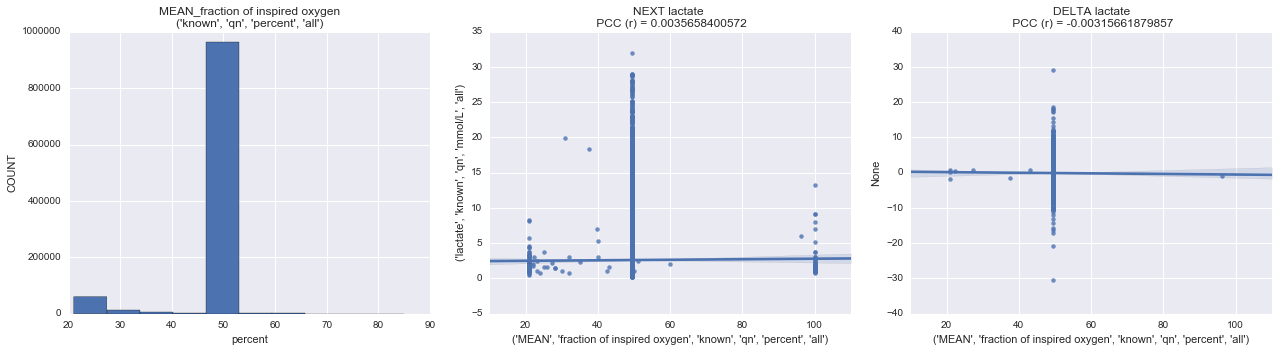

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,fraction of inspired oxygen
,unknown
,qn
,torr
,all
count,1088895.000
mean,0.494
std,0.067
min,0.210
25%,0.494


877412
0.805782008366


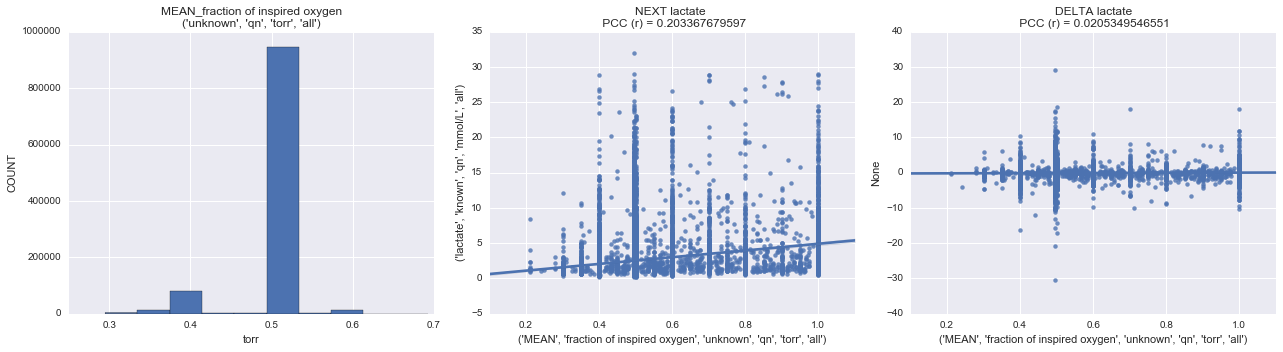

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,glucose fingerstick
,unknown
,qn
,no_units
,all
count,1088895.000
mean,144.719
std,28.153
min,0.000
25%,144.719


733359
0.673489179397


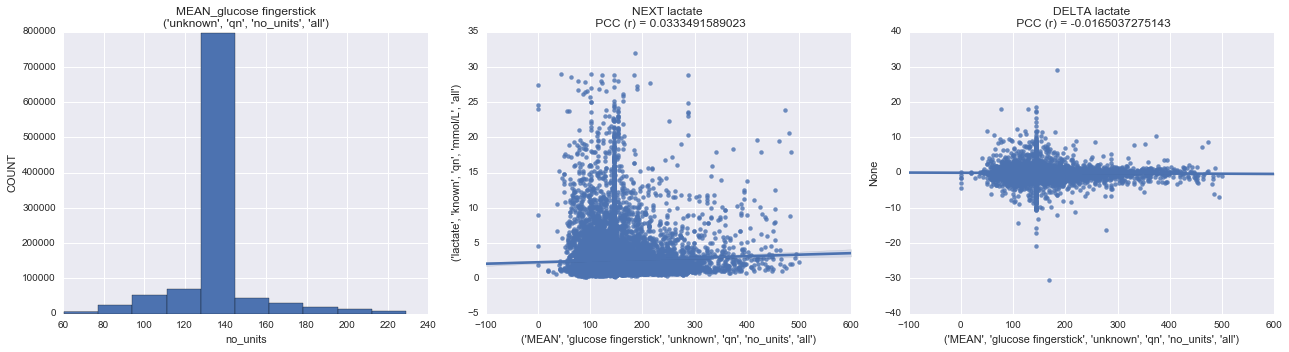

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,glucose serum
,known
,qn
,mg/dL
,all
count,1088895.000
mean,130.341
std,38.652
min,0.000
25%,122.000


569402
0.522917269342


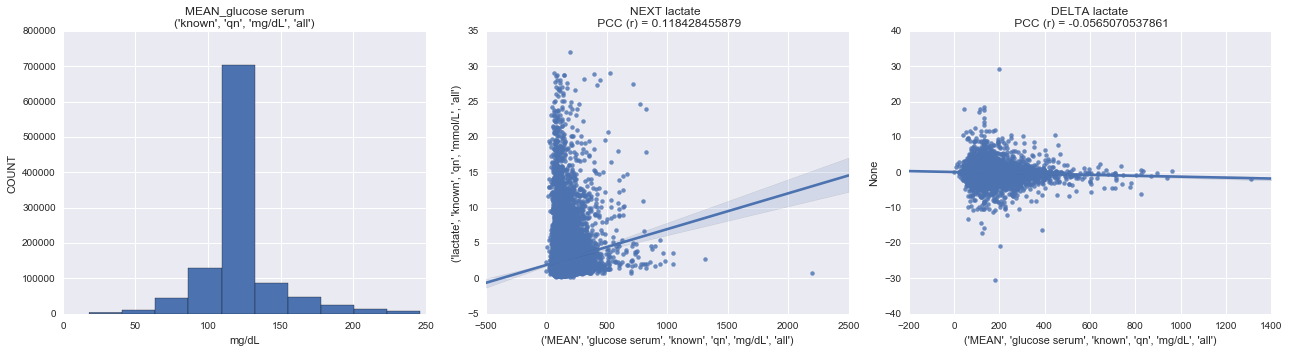

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,heart rate
,known
,qn
,beats/min
,all
count,1088895.000
mean,103.767
std,25.677
min,0.000
25%,89.333


476765
0.437842950881


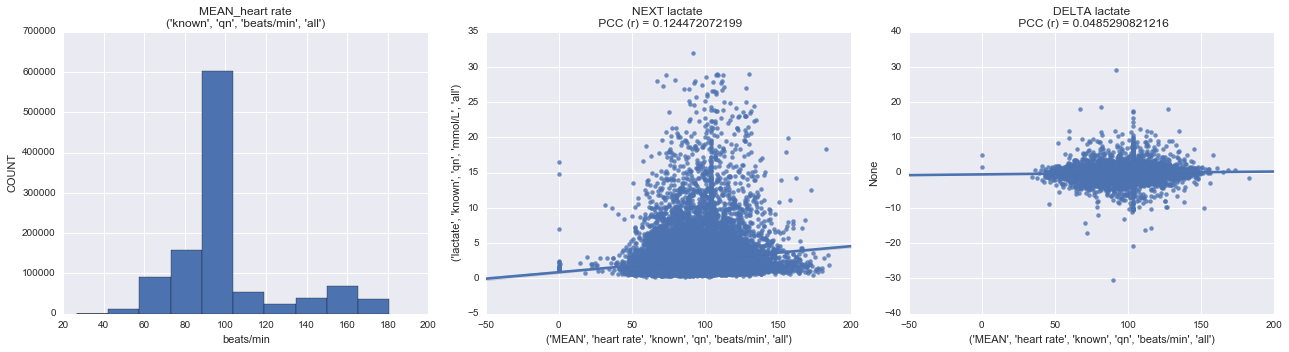

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,hematocrit
,known
,qn
,percent
,all
count,1088895.000
mean,32.739
std,5.639
min,0.000
25%,30.000


452578
0.415630524523


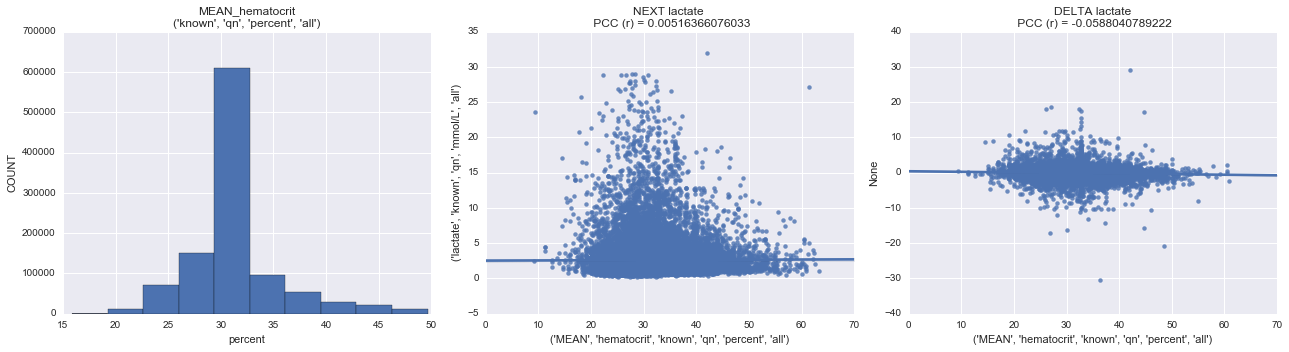

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,hemoglobin
,known
,qn
,g/dL
,all
count,1088895.000
mean,11.069
std,1.957
min,0.000
25%,10.200


456468
0.419202953453


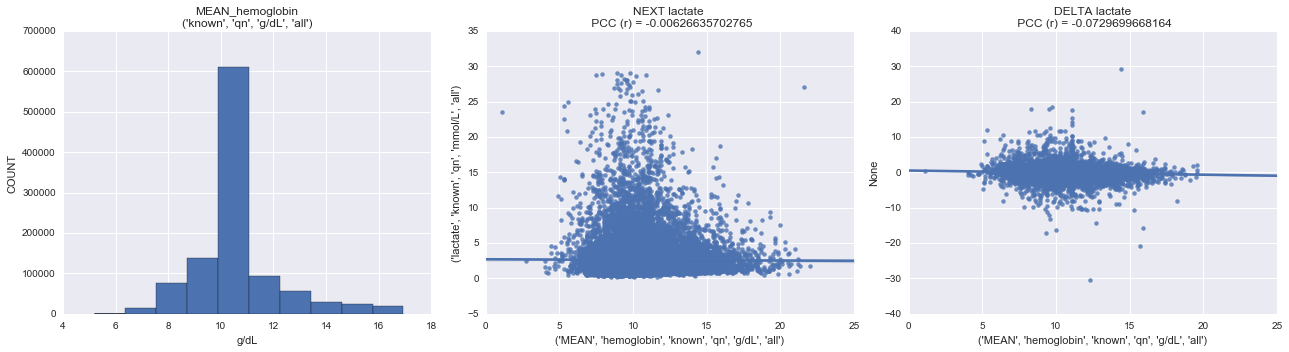

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,international normalized ratio
,unknown
,qn
,no_units
,all
count,1088895.000
mean,1.413
std,0.553
min,0.000
25%,1.300


612018
0.562054192553


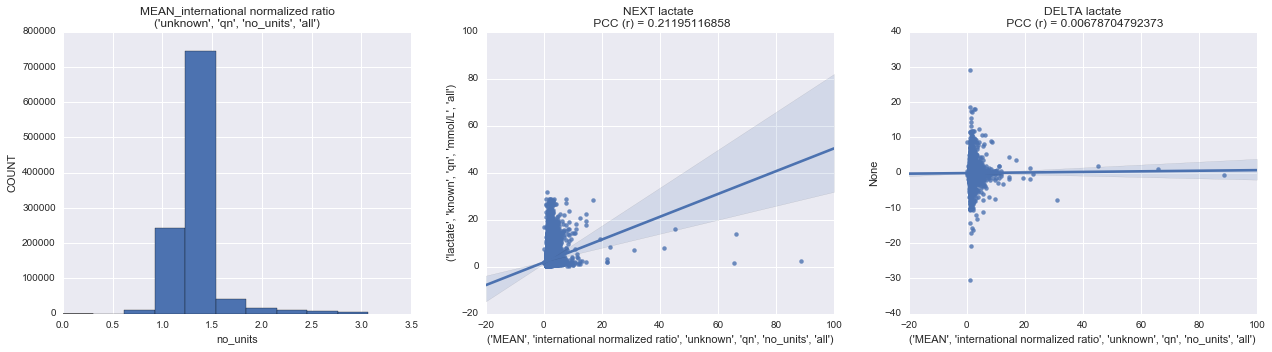

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,lactate
,known
,qn
,mmol/L
,all
count,1088895.000
mean,1.778
std,0.828
min,0.200
25%,1.778


712680
0.654498367611


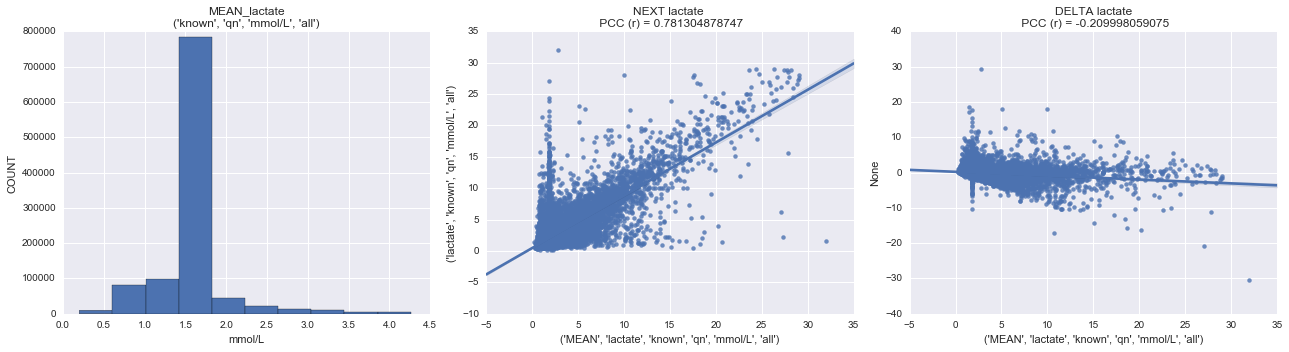

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,magnesium serum
,unknown
,qn
,mg/dL
,all
count,1088895.000
mean,2.091
std,0.745
min,0.200
25%,2.091


591592
0.543295726402


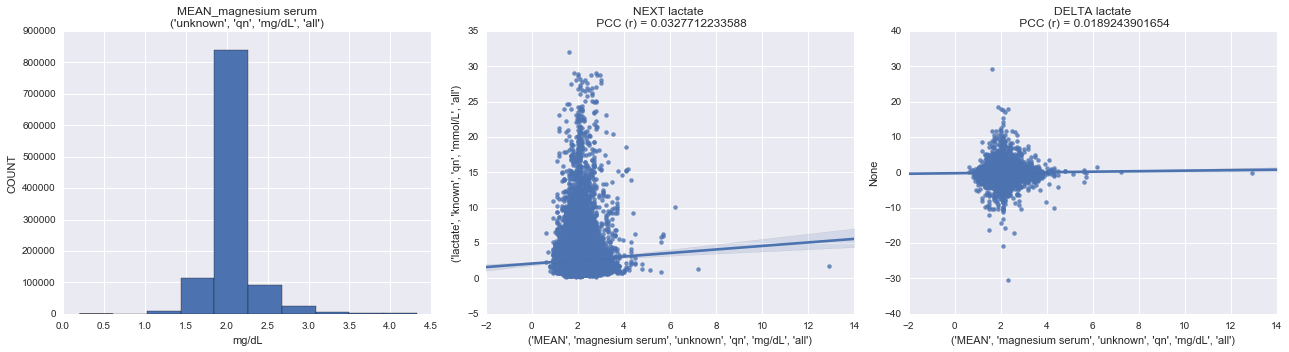

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


,MEAN
,mean corpuscular hemoglobin concentration
,unknown
,qn
,percent
,all
count,1088895.000
mean,33.590
std,1.143
min,0.000
25%,33.400


460504
0.422909463263


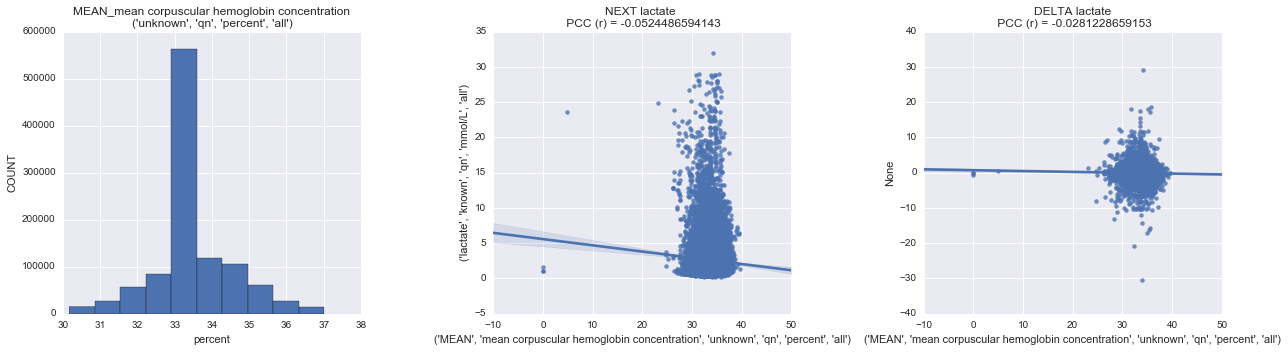

In [102]:
for col in df_train.iloc[:,:30]:
    print '@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'
    display(df_train[col].describe().apply(lambda x: '%.3f' % x).to_frame())
    
    fill_vals = dict_fill_vals.get(col[0],None)
    if fill_vals is not None:
        fill_val = fill_vals.loc[col[1:]]
        count_filled = (df_train[col] == fill_val).sum()
        print count_filled
        print count_filled/float(df_train.shape[0])
    
    
    # plot histogram of column (all of df_train)
    fig, axarr  = plt.subplots(1,3,figsize=(18, 5))
    ax = plt.subplot(1, 3, 1)
    std = df_train[col].std()
    mean = df_train[col].mean()
    df_train.loc[(df_train[col] < (mean + 3.0*std)) & (df_train[col] > (mean - 3.0*std)),col].hist()
    ax.set_title('{}_{}\n{}'.format(col[0],col[1],col[2:]))
    ax.set_xlabel(col[-2])
    ax.set_ylabel('COUNT')
    
    # plot column vs. next lactate
    ax = plt.subplot(1, 3, 2)
    sns.regplot(X_next[col], y_next)
    corr = np.corrcoef(X_next[col], y_next)[0][1]
    ax.set_title('NEXT lactate \n PCC (r) = {}'.format(corr))
    
    # plot column vs. delta lactate 
    ax = plt.subplot(1, 3, 3)
    sns.regplot(X_delta[col], y_delta)
    corr = np.corrcoef(X_delta[col], y_delta)[0][1]
    ax.set_title('DELTA lactate\n PCC (r) = {}'.format(corr))
    plt.tight_layout()
    plt.show()


In [104]:
df_train.to_hdf('data/datasets.h5','combine_like_harsh/large_data/2hr/train_20%')

## Lets see if we can reduce the fraction of fills

In [113]:
factory.resample_freq='6H'
factory.get_params()

{'ETL_manager': <mimic.MimicETLManager at 0xf4463c8>,
 'data_dict': <icu_data_defs.data_dictionary at 0xbac1ba8>,
 'features': [<features.Feature at 0xf724f98>,
 'force_preprocessing': True,
 'hdf5_fname_target': 'data/combine_like_harsh.h5',
 'pre_processors': Pipeline(steps=[('drop_small_columns', remove_small_columns(threshold=1000)), ('drop_low_id_count', record_threshold(threshold=100)), ('combine_like_columns', combine_like_cols())]),
 'pre_processors__combine_like_columns': combine_like_cols(),
 'pre_processors__drop_low_id_count': record_threshold(threshold=100),
 'pre_processors__drop_low_id_count__threshold': 100,
 'pre_processors__drop_small_columns': remove_small_columns(threshold=1000),
 'pre_processors__drop_small_columns__threshold': 1000,
 'pre_processors__steps': [('drop_small_columns',
   remove_small_columns(threshold=1000)),
  ('drop_low_id_count', record_threshold(threshold=100)),
  ('combine_like_columns', combine_like_cols())],
 'resample_freq': '6H',
 'save_ETL_

In [114]:
df_train = factory.fit_transform(train_subset)

(2017-08-03 02:06:05) FEATURIZE... #F=7, #ids=9436, fit->True
(2017-08-03 02:06:05)>> PRE-PROCESSING & JOIN: #C=57, ['alanine aminotransferase serum', 'alkaline phosphatase serum', 'aspartate aminotransferase serum', 'bicarbonate arterial', 'bicarbonate other', 'blood pressure diastolic', 'blood pressure mean', 'blood pressure systolic', 'blood urea nitrogen serum', 'calcium ionized serum', 'calcium total serum', 'carbon dioxide serum', 'central venous oxygen saturation', 'central venous pressure', 'chloride serum', 'creatinine serum', 'end tidal cardon dioxide', 'fraction of inspired oxygen', 'glasgow coma scale eye opening', 'glasgow coma scale motor', 'glasgow coma scale verbal', 'glucose fingerstick', 'glucose serum', 'heart rate', 'hematocrit', 'hemoglobin', 'international normalized ratio', 'lactate', 'lactated ringers', 'magnesium serum', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'norepinephrine', 'normal saline', 'out

In [115]:
df_train.to_hdf('data/datasets.h5','combine_like_harsh/large_data/6hr/train_20%')

In [116]:
print df_train.shape

(369251, 280)


In [117]:
factory.resample_freq='12H'
factory.get_params()

{'ETL_manager': <mimic.MimicETLManager at 0xf4463c8>,
 'data_dict': <icu_data_defs.data_dictionary at 0xbac1ba8>,
 'features': [<features.Feature at 0xf724f98>,
 'force_preprocessing': True,
 'hdf5_fname_target': 'data/combine_like_harsh.h5',
 'pre_processors': Pipeline(steps=[('drop_small_columns', remove_small_columns(threshold=1000)), ('drop_low_id_count', record_threshold(threshold=100)), ('combine_like_columns', combine_like_cols())]),
 'pre_processors__combine_like_columns': combine_like_cols(),
 'pre_processors__drop_low_id_count': record_threshold(threshold=100),
 'pre_processors__drop_low_id_count__threshold': 100,
 'pre_processors__drop_small_columns': remove_small_columns(threshold=1000),
 'pre_processors__drop_small_columns__threshold': 1000,
 'pre_processors__steps': [('drop_small_columns',
   remove_small_columns(threshold=1000)),
  ('drop_low_id_count', record_threshold(threshold=100)),
  ('combine_like_columns', combine_like_cols())],
 'resample_freq': '12H',
 'save_ETL

In [118]:
df_train = factory.fit_transform(train_subset)

(2017-08-03 02:31:03) FEATURIZE... #F=7, #ids=9436, fit->True
(2017-08-03 02:31:03)>> PRE-PROCESSING & JOIN: #C=57, ['alanine aminotransferase serum', 'alkaline phosphatase serum', 'aspartate aminotransferase serum', 'bicarbonate arterial', 'bicarbonate other', 'blood pressure diastolic', 'blood pressure mean', 'blood pressure systolic', 'blood urea nitrogen serum', 'calcium ionized serum', 'calcium total serum', 'carbon dioxide serum', 'central venous oxygen saturation', 'central venous pressure', 'chloride serum', 'creatinine serum', 'end tidal cardon dioxide', 'fraction of inspired oxygen', 'glasgow coma scale eye opening', 'glasgow coma scale motor', 'glasgow coma scale verbal', 'glucose fingerstick', 'glucose serum', 'heart rate', 'hematocrit', 'hemoglobin', 'international normalized ratio', 'lactate', 'lactated ringers', 'magnesium serum', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'norepinephrine', 'normal saline', 'out

In [119]:
df_train.to_hdf('data/datasets.h5','combine_like_harsh/large_data/12hr/train_20%')

In [120]:
print df_train.shape

(188997, 280)


# Models